In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 1.0
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5] if i in [0,3] else [0.25,0.25],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5] if i in [0,3] else [0.25,0.25],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9500]), and xy span tensor([0.2500, 0.2500])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9000]), and xy span tensor([0.2500, 0.2500])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.2000]), and xy 

In [8]:
def sig_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z > 0.4 and z <= 0.5: rad_length[7:,6:] = X0['uranium']
    return rad_length

In [9]:
def bkg_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    return rad_length

# Volume classifier

In [10]:
from tomopt.inference.volume import AbsVolumeInferer, AbsX0Inferer
from tomopt.inference.scattering import ScatterBatch


class BlockClassifierFromX0s(AbsVolumeInferer):
    def __init__(self, n_block_voxels:int, partial_x0_inferer: Type[AbsX0Inferer], volume:Volume, use_avgpool:bool=True, cut_coef=1e4, ratio_offset=-1, ratio_coef=5):
        super().__init__(volume=volume)
        self.use_avgpool, self.cut_coef,self.ratio_offset,self.ratio_coef = use_avgpool,cut_coef,ratio_offset,ratio_coef
        self.x0_inferer = partial_x0_inferer(self.volume)
        self.frac = n_block_voxels/self.volume.centres.numel()
        
        self.efficiencies: List[Tensor] = []
        self.efficiency: Optional[Tensor] = None
        self.scatter_batches = self.x0_inferer.scatter_batches
            

    def compute_efficiency(self, scatters: ScatterBatch) -> Tensor:
        return self.x0_inferer.compute_efficiency(scatters=scatters)
    

    def add_scatters(self, scatters: ScatterBatch) -> None:
        self.x0_inferer.add_scatters(scatters)
        self.efficiencies.append(self.compute_efficiency(scatters=scatters))

    def _get_weight(self) -> Tensor:
        """Maybe alter this to include resolution/pred uncertainties"""
        return self.efficiency.sum()

    def get_prediction(self) -> Tuple[Optional[Tensor], Optional[Tensor]]:
        self.efficiency = torch.cat(self.efficiencies, dim=0)
        vox_preds, vox_weights = self.x0_inferer.get_prediction()
        if self.use_avgpool:
            vox_preds = F.avg_pool3d(vox_preds[None], kernel_size=3, stride=1, padding=1, count_include_pad=False)[0]
        
        flat_preds = vox_preds.flatten()
        cut = flat_preds.kthvalue(1+round(self.frac*(flat_preds.numel()-1))).values
        
        w_bkg =  torch.sigmoid(self.cut_coef*(flat_preds-cut))
        w_blk = 1-w_bkg
        
        mean_bkg = (w_bkg*flat_preds).sum()/w_bkg.sum()
        mean_blk = (w_blk*flat_preds).sum()/w_blk.sum()
        
        r = 2*(mean_bkg-mean_blk)/(mean_bkg+mean_blk)
#         r = (r+self.ratio_offset)*self.ratio_coef
        pred = torch.sigmoid(r)
        weight = self._get_weight()
        return pred[None,None], weight

# Optimisation

In [70]:
volume = Volume(get_layers())

In [71]:
volume.get_cost()

tensor(1.2500, grad_fn=<AddBackward0>)

In [72]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator

class SameBlockPassive(AbsPassiveGenerator):
    def _generate(self) -> Tuple[Callable[..., Tensor], Optional[Tensor]]:
        if torch.rand(1) > 0.5:
            return sig_rad_length, Tensor([X0['uranium']])
        else:
            return bkg_rad_length, Tensor([X0['beryllium']])


In [73]:
passives = PassiveYielder(SameBlockPassive(volume), n_passives=4)

In [74]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [75]:
class ClassPredHandler(PredHandler):
    def __init__(self, x02id:Dict[float, int]):
        self.x02id = x02id
        
    def on_x0_pred_end(self) -> None:
        if self.wrapper.fit_params.state == "test":
            targ = self.wrapper.volume.target.detach().cpu().clone()
            for x0 in targ.unique():
                targ[targ == x0] = self.x02id[min(self.x02id, key=lambda x: abs(x - x0))]
            self.preds.append((self.wrapper.fit_params.pred.detach().cpu().numpy(), targ.numpy()))

In [76]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VolumeClassLoss(x02id={X0['beryllium']:0, X0['uranium']:1}, target_budget=None),
                             partial_volume_inferer=partial(BlockClassifierFromX0s, n_block_voxels=12, partial_x0_inferer=PanelX0Inferer, volume=volume, ratio_offset=-1, ratio_coef=5))

## Initial performance

In [77]:
test_passives = PassiveYielder(SameBlockPassive(volume), n_passives=200)

In [78]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                pred_cb=ClassPredHandler(x02id={X0['beryllium']:0, X0['uranium']:1}),
                cbs=[MuonResampler()])

In [79]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

<ipython-input-79-9804e60ffd94>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])


In [80]:
df_start['gen_target'] = df_start.gen_target.astype(int)

## Optimise

CostCoefWarmup: Freezing optimisation for 5 epochs
PanelOptConfig: Freezing optimisation for 5 epochs


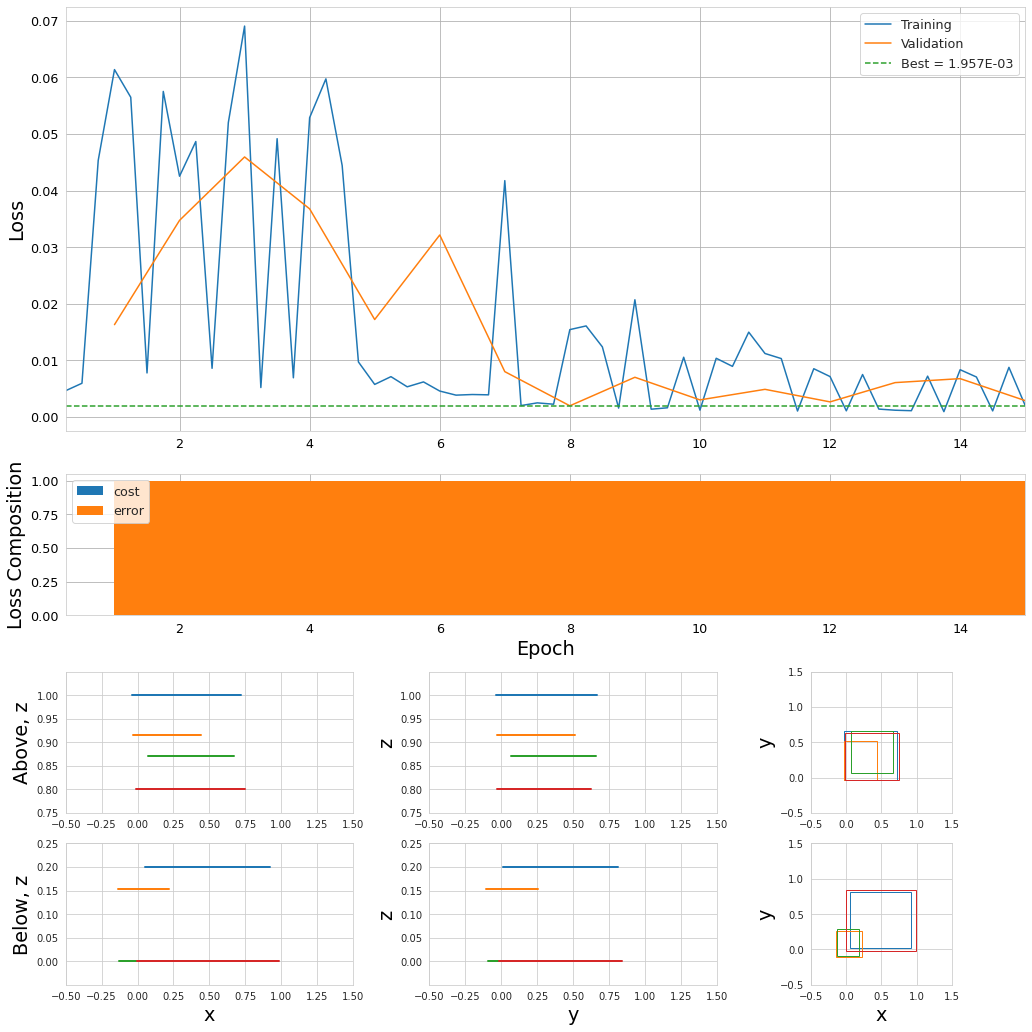

/home/centos/volume/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


Automatically setting cost coefficient to 0.004627254791557789
CostCoefWarmup: Warmed up, average error = tensor([0.0347])
PanelOptConfig: Optimiser warm-up completed
+-------------+--------------+--------------------+
|    Param    | Median Grad  |         LR         |
+-------------+--------------+--------------------+
|  xy_pos_opt | 0.0016267468 | 6.147237984867088  |
|  z_pos_opt  | 0.007692222  | 0.6500072395769675 |
| xy_span_opt | 0.0024107425 | 4.148099678773351  |
+-------------+--------------+--------------------+


<Figure size 1024x1024 with 0 Axes>

In [17]:
_ = wrapper.fit(n_epochs=15,
                passive_bs=1,
                n_mu_per_volume=250,
                mu_bs=250,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefWarmup(n_warmup=5), PanelOptConfig(n_warmup=5, xy_pos_rate=0.01, z_pos_rate=0.005, xy_span_rate=0.01), MuonResampler(), NoMoreNaNs(),PanelMetricLogger()])

In [18]:
volume.get_cost()

tensor(3.4297, grad_fn=<AddBackward0>)

## Optimised performance

In [52]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                pred_cb=ClassPredHandler(x02id={X0['beryllium']:0, X0['uranium']:1}),
                cbs=[MuonResampler()])

In [62]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

<ipython-input-62-282cd680ea81>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])


In [63]:
df_opt['gen_target'] = df_opt.gen_target.astype(int)

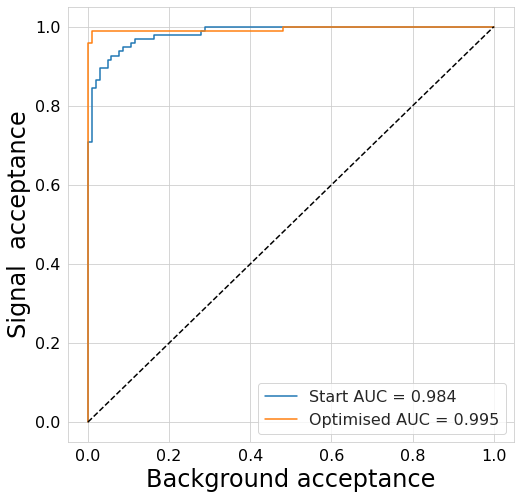

{'Start': 0.9841746794871795, 'Optimised': 0.994797919167667}

In [81]:
plot_roc((df_start, df_opt), labels=['Start', 'Optimised'])